# CNN Model Template

This notebook is a template for building a CNN model.

## Imports and inital setup

In [103]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import Callback


# import classweights
from sklearn.utils import class_weight

from time import sleep 
import cv2
import sys
import os

sys.path.append("..")
from helperfunctions import modelhelper as mh
from helperfunctions import imagehelper as ih

SEED = 856
NUM_EPOCHS = 20

# File path variables
# please make sure to use the correct path to the meta data file
FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  
FIELPATH_TESTOUTPUT= "./../data/testoutput/"
FILEPATH_MODELS= "../models/"
FILEPATH_LOGS= "../models/logs/"

TARGET_LABEL="dx_tertiary"

IMAGE_SIZE = (224, 224)

BATCH_SIZE = 32

MONITOR = 'val_loss'

### Loading (augmented) metadata as test, train, validation from files

In [104]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

lesion_id                    image_id     dx    dx_type   age     sex   
2032  HAM_0006560  aug_pKiAwOISIC_0027802.jpg  akiec      histo  50.0    male  \
3139  HAM_0000009            ISIC_0026439.jpg    bcc      histo  35.0    male   
2608  HAM_0006517            ISIC_0034076.jpg    mel      histo  55.0  female   
2529  HAM_0000062            ISIC_0028878.jpg    mel      histo  55.0    male   
960   HAM_0001781            ISIC_0028623.jpg    bkl  consensus  30.0  female   
989   HAM_0003943            ISIC_0031464.jpg    bkl      histo  80.0  female   
1328  HAM_0002730            ISIC_0026769.jpg    bkl      histo  80.0    male   
4232  HAM_0005475  aug_OnWBipISIC_0025628.jpg   vasc  consensus  80.0    male   
955   HAM_0000770            ISIC_0024741.jpg    bkl      histo  75.0    male   
1562  HAM_0005459            ISIC_0029268.jpg  akiec      histo  85.0    male   
372   HAM_0000705            ISIC_0025508.jpg     nv  follow_up  40.0  female   
2921  HAM_0001284            ISIC_0031779.jpg    mel      histo  75.0  female   
2188  HAM_0005264  aug_YbjAcDISIC_0031659.jpg  akiec      histo  45.0    male   
5019  HAM_0006794  aug_q36ikUISIC_0030830.jpg     df  consensus  50.0  female   
4873  HAM_0002909  aug_l4DumzISIC_0033675.jpg     df      histo  50.0    male   

         localization        dataset        dx_binary     dx_tertiary   
2032             face      rosendahl      skin_cancer       malignant  \
3139             back   vidir_modern      skin_cancer       malignant   
2608  lower extremity   vidir_modern      skin_cancer       malignant   
2529             back      rosendahl      skin_cancer       malignant   
960              back   vidir_modern  not_skin_cancer  non-neoplastic   
989   lower extremity      rosendahl  not_skin_cancer  non-neoplastic   
1328            scalp   vidir_modern  not_skin_cancer  non-neoplastic   
4232          abdomen  vidir_molemax  not_skin_cancer  non-neoplastic   
955   lower extremity      rosendahl  not_skin_cancer  non-neoplastic   
1562  upper extremity      rosendahl      skin_cancer       malignant   
372              back  vidir_molemax  not_skin_cancer          benign   
2921              ear   vidir_modern      skin_cancer       malignant   
2188             back      rosendahl      skin_cancer       malignant   
5019          genital  vidir_molemax  not_skin_cancer  non-neoplastic   
4873  lower extremity   vidir_modern  not_skin_cancer  non-neoplastic   

                                     image_path  
2032  ./../data/jpgs/aug_pKiAwOISIC_0027802.jpg  
3139            ./../data/jpgs/ISIC_0026439.jpg  
2608            ./../data/jpgs/ISIC_0034076.jpg  
2529            ./../data/jpgs/ISIC_0028878.jpg  
960             ./../data/jpgs/ISIC_0028623.jpg  
989             ./../data/jpgs/ISIC_0031464.jpg  
1328            ./../data/jpgs/ISIC_0026769.jpg  
4232  ./../data/jpgs/aug_OnWBipISIC_0025628.jpg  
955             ./../data/jpgs/ISIC_0024741.jpg  
1562            ./../data/jpgs/ISIC_0029268.jpg  
372             ./../data/jpgs/ISIC_0025508.jpg  
2921            ./../data/jpgs/ISIC_0031779.jpg  
2188  ./../data/jpgs/aug_YbjAcDISIC_0031659.jpg  
5019  ./../data/jpgs/aug_q36ikUISIC_0030830.jpg  
4873  ./../data/jpgs/aug_l4DumzISIC_0033675.jpg

## Setting up the image data generator for training and validation

In [105]:
def custom_preprocessing(np_image, image_size, show_image=False):
    # print the image
    # print("From custom_preprocessing: Image + shape before preprocessing:", np_image.shape)
    np_image = np_image.astype(np.uint8)
    
    #print(np_image)
    if show_image:
        plt.imshow(np_image.astype(np.uint8))
        plt.show()

    # rescale 
    np_image = np_image / 255.0

    # Using the image helper functions
    np_image = ih.center_crop_image(np_image) # Crop image to square format
    
    if show_image:
        print("From custom_preprocessing: Image after center crop:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    np_image = ih.resize_as_preprocess(np_image, image_size) # resize the image

    if show_image:
        print("From custom_preprocessing: Image after after resizing:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    return np_image

In [106]:
#print("sample augmented image from HDD:")
sample_img_path = "./../data/jpgs/aug_s8yXnVISIC_0030555.jpg"
sample_img = plt.imread(sample_img_path)

# normalize the pixel values as it would happen in the model
#sample_img = sample_img / 255.0

processed_img = custom_preprocessing(sample_img, IMAGE_SIZE, show_image=False) 

#print("sample orig image from HDD:")
sample_img_path = "./../data/jpgs/ISIC_0030571.jpg"
sample_img = plt.imread(sample_img_path)

# normalize the pixel values as it would happen in the model

processed_img = custom_preprocessing(sample_img, IMAGE_SIZE, show_image=False)

In [107]:
# Setting up the Image Data Generator for the train data set

datagen_train = ImageDataGenerator(
    rotation_range=180, # Degree range for random rotations
    horizontal_flip=True, # Randomly flip inputs horizontally
    vertical_flip=True, # Randomly flip inputs vetically
    zoom_range=0.2, # Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range]
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE), # Apply the custom preprocessing function 
)

datagen_validation = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE)
)

train_data_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    color_mode='rgb',
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,

    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 5254 validated image filenames belonging to 3 classes.
Found 1001 validated image filenames belonging to 3 classes.


In [108]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())    
    images, labels = next(gen)  
    plt.figure(figsize=(25, 25))
    length = len(labels)
    if length < 25:  
        r = length
    else:
        r = 25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image = images[i]  
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

In [109]:
images, labels = next(train_data_generator)
print(images.min(), images.max(), images.dtype)

0.0 1.0 float32


In [110]:
show_image_samples(train_data_generator)

# Using MobileNet V3 large

## Model setup

### Class weights

In [111]:
# calculating class weights

classes = np.unique(train_data_generator.classes)
y_train = train_data_generator.classes

print("classes:", classes)
print("y_train:", y_train)

class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = classes, 
    y = y_train)

print("class weights:", class_weights)

# Convert the computed class weights to a dictionary for use in TensorFlow
class_weight_dict = {i: class_weights[i] for i in range(len(classes))}

print("class_weight_dict:", class_weight_dict)

classes: [0 1 2]
y_train: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### Metric: f1 score

In [112]:
def f1_score(y_true, y_pred):
    # Calculate precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())

    # Calculate recall
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    # Calculate F1 score
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Loss function: focal loss

In [113]:
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1 + K.epsilon())) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

### Callback: ReaduceLROnPlateau

In [114]:
reduce_lr = ReduceLROnPlateau(monitor=MONITOR, factor=0.2, patience=3, verbose=1, min_lr=0.00001)

### Callback: EarlyStopping

In [115]:
stop_early = EarlyStopping(
    monitor=MONITOR,
    min_delta=0,
    patience=2,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=5,
    )

### Callback: ModelCheckpoint

In [116]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=FILEPATH_MODELS,
    save_weights_only=True,
    monitor=MONITOR,
    mode='max',
    save_best_only=True)

### Callback: TensorBoard

In [117]:
tensorboard = TensorBoard(
    log_dir=FILEPATH_LOGS,
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq="epoch",
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None,
)

### Callback: Image Comparison

In [118]:
class ImageComparisonCallback(Callback):
    def __init__(self, generator, base_dir):
        super(ImageComparisonCallback, self).__init__()
        self.generator = generator
        self.base_dir = base_dir

    def on_epoch_begin(self, epoch, logs=None):
        # Reset the generator
        self.generator.reset()

        # Get the first batch of images from the generator
        img_gen_batch, _ = next(self.generator)
        
        # Get the index of the first image in this batch relative to self.generator.filenames
        idx = self.generator.index_array[0]
        
        # Pick the image from the batch using this index and its corresponding filename
        img_gen_array = img_gen_batch[0]
        filename = self.generator.filenames[idx]

        # Load the corresponding image from disk
        img_path = os.path.join(self.base_dir, filename)
        img_disk = image.load_img(img_path, target_size=self.generator.image_shape[:2])
        img_disk_array = image.img_to_array(img_disk)

        # Compare the two arrays
        is_same = np.array_equal(img_disk_array, img_gen_array)
        if is_same:
            print("The images are identical!")
        else:
            print("The images are different!")
            np.array_diff = img_disk_array - img_gen_array

        # Display both images for comparison
        fig, axes = plt.subplots(1, 2, figsize=(8, 3))
        axes[0].imshow(img_disk_array.astype('uint8'))
        axes[0].set_title(f'Image from Disk: {filename}')
        axes[0].axis('off')

        # If the generator normalizes images to [0,1], we multiply by 255 for proper visualization
        axes[1].imshow((img_gen_array*255).astype('uint8'))
        axes[1].set_title('Image from Generator')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

# Usage: Assuming you have already defined a generator, `train_generator`, and a base directory, `data_dir`
# callback = ImageComparisonCallback(train_generator, data_dir)

base_dir = FILEPATH_JPGS

### Optimizer: SDG

In [119]:
opt = SGD(learning_rate=0.0001, 
            momentum=0.9
            # nesterov=True,
            # decay=0.01
            )

### Model: Name

In [120]:
NAME = "tertiary_mobileNet_trainable-weights_weights-balanced"

### Model: Architecture

In [121]:
PRETRAINED = False

if PRETRAINED:
    # Initialize the MobileNetV3Large model
    base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    # Freeze the base model's layers to use it for feature extraction
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top 
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(base_model.output)

    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)

    # Global average pooling instead of flattening
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dense(128, activation='relu')(x)

    x = layers.Dropout(0.5)(x)  # 50% dropout /new

    x = layers.Dense(train_df[TARGET_LABEL].nunique(), activation='softmax')(x) 

    # Create the full model
    model = Model(inputs=base_model.input, outputs=x, name=NAME)

    # Setting an optimizer
    opt = SGD(learning_rate=0.0001, 
                momentum=0.9
                # nesterov=True,
                # decay=0.01
              )

    # Compile the model
    model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=[
                        'accuracy',
                        f1_score
                        ])

    model.summary()

else:
    # Initialize the MobileNetV3Large model
    base_model = MobileNetV3Large(weights=None, include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    # Freeze the base model's layers to use it for feature extraction
    for layer in base_model.layers:
        layer.trainable = True

    # Add custom layers on top 
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(base_model.output)

    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)

    # Global average pooling instead of flattening
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # x = layers.Dense(128, activation='relu')(x)

    x = layers.Dropout(0.7)(x)  #dropout

    x = layers.Dense(train_df[TARGET_LABEL].nunique(), activation='softmax')(x) 

    # Create the full model
    model = Model(inputs=base_model.input, outputs=x, name=NAME)
    
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=[
                        'accuracy',
                        f1_score
                        ])

    model.summary()


Model: "tertiary_mobileNet_trainable-weights_weights-balanced"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 224, 224, 3)          0         ['input_6[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_5[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                    

## Model Training

In [122]:
# Train the model

history = model.fit(
    train_data_generator,
    epochs=NUM_EPOCHS,              
    verbose=1,                      # Adjust verbosity level
    batch_size=BATCH_SIZE,          # Set the batch size, default is 32, can be increased to speed up training
    callbacks=[
        reduce_lr,
        stop_early,
        tensorboard,
        model_checkpoint_callback
        ],                 
    validation_data=validation_generator,
    shuffle=True,                   # Shuffle the training data before each epoch
    sample_weight=None,             # Set the weights for the train data set
    class_weight=class_weight_dict, # Set the weights for the classes, not needed if we use sample weights
    initial_epoch=0,                # Use this to continue training from a specific epoch
    steps_per_epoch=None,           # Set the number of steps per epoch, default is len(x_train) // batch_size
    validation_freq=1,              # Only relevant if validation data is a generator. Set the frequency to validate the model on the validation set
    max_queue_size=10,              # Set the max size for the generator queue
    workers=-1,                     # Set the max number of processes to generate the data in parallel, -1 means all CPUs
    use_multiprocessing=False       # Set to True if you use a generator in parallel, e.g. model.predict_generator()
)

Epoch 1/20
165/165 [==============================] - 324s 2s/step - loss: 1.1130 - accuracy: 0.3346 - f1_score: 0.0695 - val_loss: 1.0911 - val_accuracy: 0.6693 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
165/165 [==============================] - 331s 2s/step - loss: 1.0482 - accuracy: 0.4052 - f1_score: 0.0887 - val_loss: 1.1607 - val_accuracy: 0.1359 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/20
165/165 [==============================] - 338s 2s/step - loss: 0.9715 - accuracy: 0.4781 - f1_score: 0.1955 - val_loss: 1.1943 - val_accuracy: 0.1359 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/20
165/165 [==============================] - ETA: 0s - loss: 0.9109 - accuracy: 0.4890 - f1_score: 0.2449
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
165/165 [==============================] - 331s 2s/step - loss: 0.9109 - accuracy: 0.4890 - f1_score: 0.2449 - val_loss: 1.2420 - val_accuracy: 0.1359 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 5/20


## Plotting accuracy and loss of train and validation set

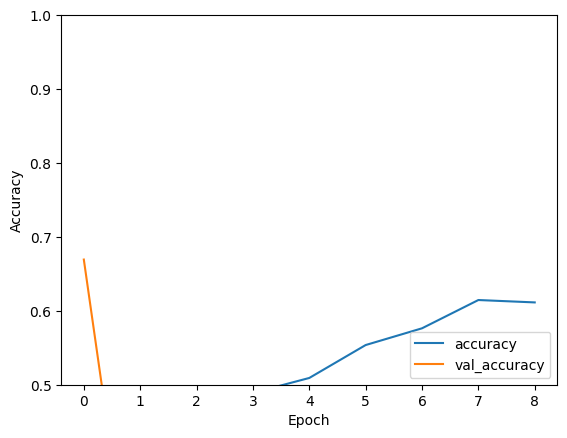

In [123]:
mh.model_plot_accuracy(history)

## Evaluating the model on the test set

 > Evaluating model tertiary_mobileNet_trainable-weights_weights-balanced:
 > Loading test images...
 > Test images loaded.


 > Converting labels to one hot format...
 > Getting model predictions...
32/32 [==============================] - 10s 266ms/step
 > Model predictions obtained.
 > Macro AUC: 0.5892246624785673
 > Micro AUC: 0.25641904813128236


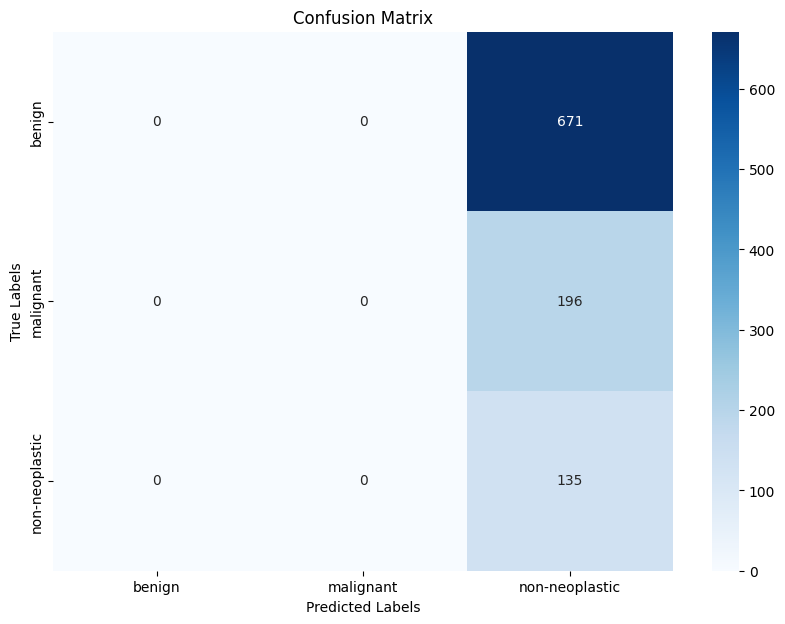



 > Computing classification report...
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       671
           1       0.00      0.00      0.00       196
           2       0.13      1.00      0.24       135

    accuracy                           0.13      1002
   macro avg       0.04      0.33      0.08      1002
weighted avg       0.02      0.13      0.03      1002

 > Evaluating model on test set...


/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

32/32 [==============================] - 8s 243ms/step - loss: 1.2363 - accuracy: 0.1347 - f1_score: 0.0000e+00
loss: 1.236311912536621
accuracy: 0.1347305327653885
f1_score: 0.0
 > Done.


([{'loss': 1.236311912536621},
  {'accuracy': 0.1347305327653885},
  {'f1_score': 0.0}],
 array([[  0,   0, 671],
        [  0,   0, 196],
        [  0,   0, 135]]),
 (0.25641904813128236, 0.5892246624785673))

In [124]:
mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

## Saving the model

In [125]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"{FILEPATH_MODELS}model_{timestamp}.h5"
model.save(model_path)

/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
